**# Classifying images of imagewoof objects using a neural network**

1.we are here classifying dogs into its breeds.
2.here we are using dogs images
3.it is classification problem 

In [5]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [6]:
!pip install jovian --upgrade --quiet

In [7]:
project_name = 'finalproject'

In [8]:
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
import torch
import torchvision
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

**Exploring the imagewoof dataset**

In [9]:
#download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-160.tgz"
download_url(dataset_url, '.')

# extract the archive

with tarfile.open('./imagewoof-160.tgz', 'r:gz') as tar: #read file in r mode
  tar.extractall(path = './data') #extract all folders from zip file and store under folder named data

Using downloaded and verified file: ./imagewoof-160.tgz


In [10]:
data_dir = './data/imagewoof-160'
print(os.listdir('./data/imagewoof-160/train'))
print(len(os.listdir('./data/imagewoof-160/train')))
print(os.listdir(data_dir))

['n02105641', 'n02115641', 'n02093754', 'n02099601', 'n02096294', 'n02088364', 'n02111889', 'n02087394', 'n02086240', 'n02089973']
10
['val', 'train']


In [11]:
classes = ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog']
num_classes =len(classes)
print(num_classes,classes)


10 ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog']


In [12]:
test_directory = './data/imagewoof-160/val'

In [13]:
dataset  = ImageFolder('./data/imagewoof-160/train', tt.ToTensor())


In [14]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_1 = tt.Compose([tt.RandomCrop(160, padding=1, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(degrees=15),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

test_1 = tt.Compose([tt.RandomResizedCrop(160),
                        tt.ToTensor(), tt.Normalize(*stats)])

In [15]:
dataset = ImageFolder(data_dir + '/train', train_1)
test_dataset  = ImageFolder(data_dir + '/val', test_1)

In [16]:
test_dataset_size = len(test_dataset)
test_dataset_size

500

In [17]:
img, label = dataset[500]
img_shape = img.shape
img_shape


torch.Size([3, 160, 160])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label (numeric): 0
Label (textual): Australian terrier


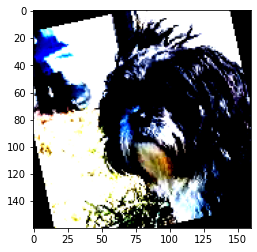

In [18]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [19]:
dataset_size = len(dataset)
dataset_size

12454

In [ ]:
img_set = {}
for j in range(num_classes):
    img_set[classes[j]] = 0

for j in range(dataset_size):
    img, label = dataset[j]
    img_set[classes[label]] += 1

img_set

# **Preparing the data for training**

We'll use a validation set with 5000 images. To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [ ]:
torch.manual_seed(43)
val_size = 500
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
jovian.log_dataset(val_size = 5000, random_seed = 43)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [ ]:
train_loader  = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 4, pin_memory=True)
val_loader  = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
img, label = dataset[52]
print(img.shape, label)
img
classedict = dict(zip(dataset.classes, classes))
classedict

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
jovian.commit(project=project_name, environment=None)

# **Base Model class & Training on GPU**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
        


In [ ]:
class model1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 80 x 80

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 40 x 40

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 256 x 10 x 10

            nn.Flatten(), 
            nn.Linear(256*10*10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = model1()
model

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [ ]:
torch.cuda.is_available()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)



In [ ]:
to_device(model, device);

# **Training the model**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model1(), device)

In [ ]:
evaluate(model, val_loader)


In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.1

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

In [ ]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

In [ ]:
history = fit(5, 0.02, model, train_loader, val_loader, torch.optim.Adam)

In [ ]:
history = fit(5, 0.009, model, train_loader, val_loader, torch.optim.Adam)

In [ ]:
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_loss = history[-1]['val_loss'],
                   val_acc = history[-1]['val_acc'])

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

# **Recoding your results**

In [ ]:
arch = (12000,10000,5000,500,10)

In [ ]:
lrs = [0.4,.04,.004,.0002]

In [ ]:
epochs = [5,5,5,5]

In [ ]:
test_acc = 0.2228163480758667
test_loss =2.151336908340454

In [ ]:
jovian.reset()

In [ ]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)

In [ ]:
evaluate(model, test_loader)

In [ ]:
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)

# **summary- **

intially i was starting form two hidden layer then accuracy is less then i increase the hidden layer then i got better accuracy. if we implement better loss function then it increase the accuracy.

In [ ]:
jovian.commit(project=project_name)